In [2]:
import dask
from dask import dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import open3d as o3d
import math
import pandas as pd
from scipy.spatial import Delaunay
from functools import reduce

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
data = r"D:\Dropbox\P.Robeck\BPLA Dropbox\07 Temp\Drone-data\Namar_Daharat_P2andP3\11_Pointcloud\Converted_XYZ\*.txt"

In [4]:
pdcloud = dd.read_csv(data, sep=' ', header=None, names = ['x','y','z','r','g','b'],index_col=False, dtype = {'x':float,'y':float,'z':float,'r':int,'g':int,'b':int})
pdcloud["geometry"] = dg.points_from_xy(pdcloud,"x","y","z")
gdf = dg.from_dask_dataframe(pdcloud, geometry="geometry")
# gdf_cl = gdf.compute(npartitions = 12)

c:\Users\Robeck\Downloads\point-pip\.venv\lib\site-packages\dask\dataframe\io\csv.py:632: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


In [5]:
# polygon vector
annotations = gpd.read_file(r"D:\Dropbox\P.Robeck\BPLA Dropbox\03 Planning\1350 - Dharat Namar Phase 2+3\02_Drawings\01 DRAWINGS\GIS\GIS-data\202312-dumping\202312-dumping-v4.gpkg")
annotations = annotations.to_crs("EPSG:32638")
# annotations['geometry'] = annotations.geometry.buffer(1)
annotations_ddf = dg.from_geopandas(annotations, npartitions = 12)
pointInPolys = dg.sjoin(gdf, annotations_ddf, predicate="within", how='inner')
gdf_cloud = pointInPolys.compute(npartitions = 12)

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_BAG.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_GMT.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load r

In [111]:
npcloud=gdf_cloud.to_numpy()
gdf_cloud.head()

,x,y,z,r,g,b,geometry,index_right,type
573969,656580.702026,2.715596e+06,766.531006,182,165,134,POINT Z (656580.702 2715596.064 766.531),321,0
574020,656580.705017,2.715596e+06,766.512024,177,161,130,POINT Z (656580.705 2715596.209 766.512),321,0
574031,656580.706970,2.715593e+06,766.622986,186,166,138,POINT Z (656580.707 2715593.250 766.623),321,0
574081,656580.708984,2.715596e+06,766.502014,184,166,136,POINT Z (656580.709 2715596.354 766.502),321,0
574137,656580.713989,2.715596e+06,766.491028,188,169,139,POINT Z (656580.714 2715596.500 766.491),321,0


In [8]:
ch_dict = {"fid": [], "height":[],"volume": [], "points": []}


for i in np.unique(npcloud[:,7]):
    # print(i)
    # xzy format
    subset = npcloud[npcloud[:,7] == i, ]
    subsetBase = np.copy(subset)

    p = np.percentile(subsetBase[:,2], 15)
    subsetBase[:,2]  = p
    # subsetBase[:,2]  = min(subset[:,2])
    base = np.append(subset, subsetBase, axis=0)


    baseAr = [tuple(row) for row in base[:,0:3]]
    baseAr = np.unique(baseAr, axis=0)
    height = max(subset[:,2])-p
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(subset[:, [0,2,1]])
    # pcd.points = o3d.utility.Vector3dVector(baseAr[:, :3])
    pcd.estimate_normals()
    pcd.compute_convex_hull()
    
    try:
        ch, _ = pcd.compute_convex_hull()
        chv = ch.get_volume()
    
    except RuntimeError:
        chv = 0

    ch_dict["fid"].append(i)
    ch_dict['height'].append(height)
    ch_dict["volume"].append(chv)
    ch_dict["points"].append(baseAr.shape[0])

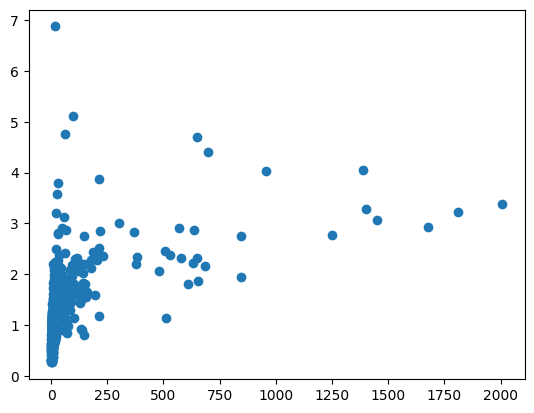

In [9]:
import matplotlib.pyplot as plt
plt.scatter(ch_dict["volume"],ch_dict["height"])

In [10]:
pd.DataFrame(ch_dict['volume']).mean()

0    39.498118
dtype: float64

In [11]:
annotations['fid'] = annotations.index
ch = annotations.merge(pd.DataFrame.from_dict(ch_dict), on='fid')

In [12]:
pd.DataFrame.from_dict(ch_dict).shape

(1317, 4)

# Mesh volume

In [13]:
def get_triangles_vertices(triangles, vertices):
    triangles_vertices = []
    for triangle in triangles:
        new_triangles_vertices = [vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]]
        triangles_vertices.append(new_triangles_vertices)
    return np.array(triangles_vertices)

def volume_under_triangle(triangle):
    p1, p2, p3 = triangle
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    return abs((z1+z2+z3)*(x1*y2-x2*y1+x2*y3-x3*y2+x3*y1-x1*y3)/6)

In [14]:
mesh_dict = {"fid": [], "volume": [], "points": []}

for i in np.unique(npcloud[:,7]):

    # i = 806# [1:100]
    try:
        # print(i)
        subset = npcloud[npcloud[:,7] == i, ]
    
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(subset[:, [0,2,1]])
        axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
        # o3d.visualization.draw_geometries([pcd, axes])
        # print(np.array(pcd.points).shape)

        plane_model, inliers = pcd.segment_plane(distance_threshold=0.02, ransac_n=3, num_iterations=10000)
        [a, b, c, d] = plane_model
        plane_pcd = pcd.select_by_index(inliers)
        # plane_pcd.paint_uniform_color([1.0, 0, 0])
        stockpile_pcd = pcd.select_by_index(inliers, invert=True)
        # stockpile_pcd.paint_uniform_color([0, 0, 1.0])
        # o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])


        plane_pcd = plane_pcd.translate((0,0,d/c))
        stockpile_pcd = stockpile_pcd.translate((0,0,d/c))

        cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
        sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
        u_1 = b / math.sqrt(a**2 + b**2 )
        u_2 = -a / math.sqrt(a**2 + b**2)

        rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                                    [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                                    [-u_2*sin_theta, u_1*sin_theta, cos_theta]])
        plane_pcd.rotate(rotation_matrix)
        stockpile_pcd.rotate(rotation_matrix)

        # o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])
        # o3d.visualization.draw_geometries([stockpile_pcd])
        # cl, ind = stockpile_pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=2.0)
        # stockpile_pcd = stockpile_pcd.select_by_index(ind)

        # o3d.visualization.draw_geometries([stockpile_pcd])
        downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.01)
        xyz = np.asarray(downpdc.points)
        # print(xyz)
        xy_catalog = []
        for point in xyz:
            xy_catalog.append([point[0], point[1]])

        tri = Delaunay(np.array(xy_catalog))

        surface = o3d.geometry.TriangleMesh()
        surface.vertices = o3d.utility.Vector3dVector(xyz)
        surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
        # o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)
        
        volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)/1000000
        # print(f"The volume of the stockpile {i} is: {round(volume, 4)} m3")

    except:
        volume = None

    mesh_dict["fid"].append(i)
    mesh_dict["volume"].append(volume)
    mesh_dict["points"].append(subset.shape[0])


In [15]:
mesh_df = pd.DataFrame(mesh_dict.values(), index=mesh_dict.keys()).transpose()
mesh_df["volume"].describe()

count     1317.000000
mean       107.960760
std        621.755838
min          0.007680
25%          5.946072
50%         16.518090
75%         48.172868
max      13878.485133
Name: volume, dtype: float64

In [17]:
ch_mesh = ch.merge(mesh_df, on='fid')

In [84]:
ch_mesh['len']=(ch_mesh.length-np.sqrt(np.square(ch_mesh.length)-16*ch.area))/4
ch_mesh['wid']=(ch_mesh.length+np.sqrt(np.square(ch_mesh.length)-16*ch.area))/4
ch_mesh['area']=ch_mesh.area
ch_mesh['xvol_area']=ch_mesh.volume_x/ch_mesh.area
ch_mesh['yvol_area']=ch_mesh.volume_y/ch_mesh.area


# ch_mesh['final'] = if(ch_mesh.xvol_area=<0.9,ch_mesh.x_volume,ch_mesh.y_volume)
ch_mesh['finalx'] = ch_mesh['volume_x'].where((ch_mesh['xvol_area']<=0.9) & (ch_mesh['volume_x']<ch_mesh['volume_y']), ch_mesh['volume_y'] )
ch_mesh['finaly'] = ch_mesh['volume_y'].where((ch_mesh['yvol_area']<=0.9) & (ch_mesh['volume_y']<ch_mesh['volume_x']), ch_mesh['volume_x'] )

c:\Users\Robeck\Downloads\point-pip\.venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


(array([71., 76., 66., 85., 59., 57., 64., 47., 71., 48., 54., 41., 39.,
        32., 34., 37., 47., 27., 24., 24., 27., 18., 21., 19., 18., 12.,
        14., 10.,  6., 11.,  6.,  6.,  5.,  7.,  5.,  2.,  4.,  2.,  3.,
         4.,  4.,  1.,  3.,  2.,  2.,  4.,  1.,  3.,  0.,  3.,  1.,  0.,
         0.,  1.,  4.,  2.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,
         1.,  0.,  4.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  3.,  0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
 

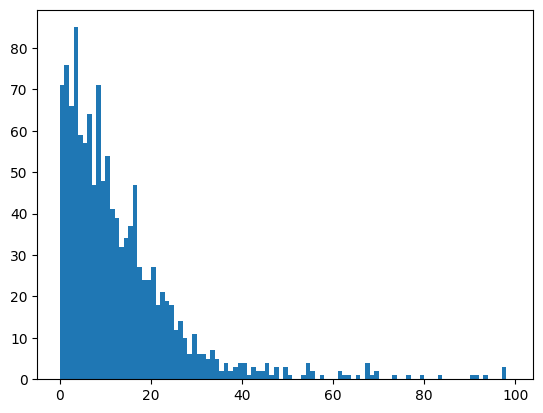

In [75]:
plt.hist(ch_mesh.finalx, bins=range(0,100))

In [80]:
print(ch_mesh.finalx.describe())
print(ch_mesh.finaly.describe())

count    1317.000000
mean       40.356450
std       290.719151
min         0.007680
25%         4.580317
50%        10.180660
75%        19.224781
max      8341.533090
Name: finalx, dtype: float64
count    1317.000000
mean       24.696989
std        83.016756
min         0.007680
25%         4.580317
50%        10.180660
75%        19.166100
max      1387.769192
Name: finaly, dtype: float64


In [81]:
print(ch_mesh.finalx.sum())
ch_mesh.finaly.sum()

53149.444537093805


32525.934714967443

In [90]:
ch_mesh.groupby('type')['finaly'].sum()
print(ch_mesh.groupby('type')['area'].sum())
print(ch_mesh.area.sum())

type
0    17733.905928
1    35385.748125
2      366.580866
Name: area, dtype: float64
53486.23491840885


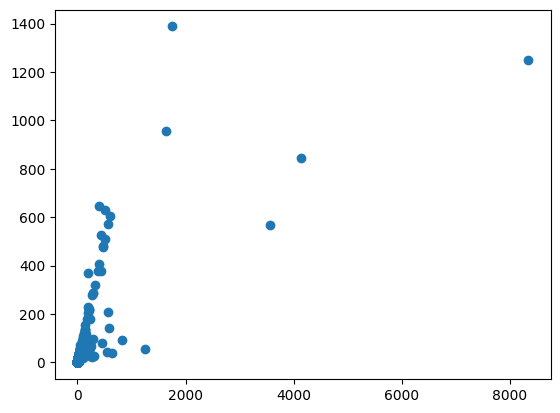

In [79]:
plt.scatter(ch_mesh.finalx,ch_mesh.finaly)

(array([  0., 831., 225.,  74.,  42.,  29.,  17.,  13.,  12.,  11.,   7.,
          2.,   4.,   9.]),
 array([-9.99665269e-01,  3.34730642e-04,  1.00033473e+00,  2.00033473e+00,
         3.00033473e+00,  4.00033473e+00,  5.00033473e+00,  6.00033473e+00,
         7.00033473e+00,  8.00033473e+00,  9.00033473e+00,  1.00003347e+01,
         1.10003347e+01,  1.20003347e+01,  1.30003347e+01]),
 <BarContainer object of 14 artists>)

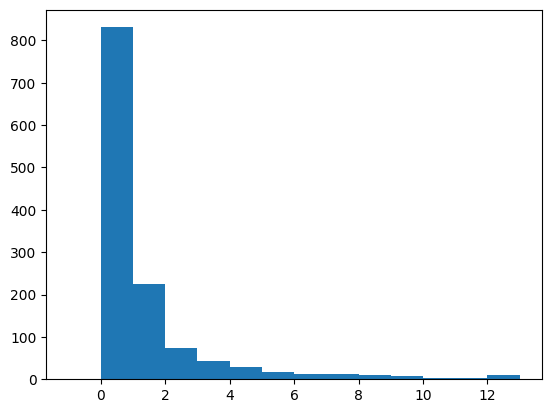

In [29]:
plt.hist(ch_mesh.yvol_area, bins=np.arange(ch_mesh.yvol_area.min()-1, ch_mesh.yvol_area.mean()+10),)

In [85]:
ch_mesh.to_file(r"D:\Dropbox\P.Robeck\BPLA Dropbox\03 Planning\1350 - Dharat Namar Phase 2+3\02_Drawings\01 DRAWINGS\GIS\GIS-data\202312-dumping\volume-output\Namar_Dharat_P3_East_PointC-13.gpkg",layer='v1',driver="GPKG")

In [108]:
subset = npcloud[npcloud[:,7] == 773, ]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(npcloud[:, [0,2,1]])
# axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()#origin=[min(subset[:,0]), min(subset[:,2]), min(subset[:,1])]
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=1)

downpdc = pcd.voxel_down_sample(voxel_size=1)


In [110]:
len(pcd.points)/len(voxel_grid.get_voxels())


41.55826227267124

In [ ]:
ch_mesh.groupby('type')['finaly'].sum()
print(ch_mesh.groupby('type')['area'].sum())
print(ch_mesh.area.sum())

type
0    17733.905928
1    35385.748125
2      366.580866
Name: area, dtype: float64
53486.23491840885


0.9659370834214125

In [153]:
subset = npcloud[npcloud[:,7] == 773, ]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(subset[:, [0,2,1]])
# axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()#origin=[min(subset[:,0]), min(subset[:,2]), min(subset[:,1])]

# axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
# ?o3d.visualization.draw_geometries([pcd, axes])
# pcd.points = o3d.utility.Vector3dVector(subset[:, :3])
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(subset[:, :3])
# axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
o3d.visualization.draw_geometries([pcd, axes])
# print(np.array(pcd.points).shape)
plane_model, inliers = pcd.segment_plane(distance_threshold=0.02,
                                         ransac_n=3,
                                         num_iterations=10000)
[a, b, c, d] = plane_model
plane_pcd = pcd.select_by_index(inliers)
plane_pcd.paint_uniform_color([1.0, 0, 0])
stockpile_pcd = pcd.select_by_index(inliers, invert=True)
stockpile_pcd.paint_uniform_color([0, 0, 1.0])
o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])

plane_pcd = plane_pcd.translate((0,0,d/c))
stockpile_pcd = stockpile_pcd.translate((0,0,d/c))
cos_theta = c / math.sqrt(a**2 + b**2 + c**2)
sin_theta = math.sqrt((a**2+b**2)/(a**2 + b**2 + c**2))
u_1 = b / math.sqrt(a**2 + b**2 )
u_2 = -a / math.sqrt(a**2 + b**2)
rotation_matrix = np.array([[cos_theta + u_1**2 * (1-cos_theta), u_1*u_2*(1-cos_theta), u_2*sin_theta],
                            [u_1*u_2*(1-cos_theta), cos_theta + u_2**2*(1- cos_theta), -u_1*sin_theta],
                            [-u_2*sin_theta, u_1*sin_theta, cos_theta]])

plane_pcd.rotate(rotation_matrix)
stockpile_pcd.rotate(rotation_matrix)
o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])


# o3d.visualization.draw_geometries([plane_pcd, stockpile_pcd, axes])
# o3d.visualization.draw_geometries([stockpile_pcd])
# cl, ind = stockpile_pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=5.0)
# stockpile_pcd = stockpile_pcd.select_by_index(ind)

# o3d.visualization.draw_geometries([stockpile_pcd])
downpdc = stockpile_pcd.voxel_down_sample(voxel_size=0.05)
xyz = np.asarray(downpdc.points)


xy_catalog = []
for point in xyz:
    xy_catalog.append([point[0], point[1]])

tri = Delaunay(np.array(xy_catalog))

surface = o3d.geometry.TriangleMesh()
# vol=surface.get_volume()
surface.vertices = o3d.utility.Vector3dVector(xyz)
surface.triangles = o3d.utility.Vector3iVector(tri.simplices)
# o3d.visualization.draw_geometries([surface], mesh_show_wireframe=True)
# vol=surface.get_volume()
volume = reduce(lambda a, b:  a + volume_under_triangle(b), get_triangles_vertices(surface.triangles, surface.vertices), 0)/1000000
# print(f"The volume of the stockpile {i} is: {round(volume, 4)} m3")


# volume = None

mesh_dict["fid"].append(i)
mesh_dict["volume"].append(volume)
mesh_dict["points"].append(subset.shape[0])
volume

In [30]:
del(pcd)